## Задача 1.4
[Выборка: новости Lenta.ru](https://github.com/yutkin/Lenta.Ru-News-Dataset)

1. Взять случайную подвыборку новостей lenta.ru за 2019 год (не менее 3000)
2. На основе подвыборки построить граф связей упоминания личностей, организаций и стран из [списка](entities.txt).
3. В новостях выбрать сущность, зависящую от наибольшего количества других сущностей (далее будем называть ее центральной)
4. посчитать ACE уопминания центральной сущности при упоминании (и отсутствии упоминания) сущностей, от которых она зависит
5. сравнить результаты пункта 4 с оценками вероятностей упоминания центральной сущности при условии упоминания (и при отсутствии упоминания) сущностей, от которых она зависит

**Рекомендации: (в случае использования пакета causality):**

1. в качестве теста для проверки условной независимости использовать MutualInformationTest
2. результаты будут сильно отличаться в зависимости от полученной случаной подвыборки. Фиксируйте seed.
3. для учета разного написания сущности (число, род, падеж) используйте методы стеминга (nltk.stem или mystem):
https://www.kaggle.com/alxmamaev/how-to-easy-preprocess-russian-text
4. causality не умеет работать с циклами (но сам их производит). Циклы можно удалять (в этой лабе, в реальности нельзя).

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

from causalgraphicalmodels import CausalGraphicalModel
from causality.inference.search import IC
from causality.inference.independence_tests import MutualInformationTest
from causality.estimation.adjustments import AdjustForDirectCauses
from causality.estimation.nonparametric import CausalEffect

import networkx as nx

In [3]:
df = pd.read_csv('lenta-ru-news.csv')

In [4]:
df.head()

,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18


In [5]:
df.shape

(800975, 6)

In [6]:
df['date'].unique()

array(['1914/09/16', '1914/09/17', '1914/09/18', ..., '2019/12/12',
       '2019/12/13', '2019/12/14'], dtype=object)

In [7]:
df['topic'].unique()

array(['Библиотека', 'Россия', 'Мир', 'Экономика', 'Интернет и СМИ',
       'Спорт', 'Культура', 'Из жизни', 'Силовые структуры',
       'Наука и техника', 'Бывший СССР', nan, 'Дом', 'Сочи', 'ЧМ-2014',
       'Путешествия', 'Ценности', 'Легпром', 'Бизнес', 'МедНовости',
       'Оружие', '69-я параллель', 'Культпросвет ', 'Крым'], dtype=object)

In [8]:
df['tags'].unique()

array(['Первая мировая', 'Все', nan, 'Прибалтика', 'Кино', 'Преступность',
       'Общество', 'Происшествия', 'Искусство', 'Бизнес', 'Техника',
       'ТВ и радио', 'Политика', 'Пресса', 'Музыка', 'Люди', 'Звери',
       'Игры', 'Госэкономика', 'Гаджеты', 'Наука', 'Еда', 'Рынки',
       'Деньги', 'Летние виды', 'Интернет', 'Театр', 'Конфликты',
       'Реклама', 'Космос', 'Бокс и ММА', 'Футбол', 'Книги',
       'Зимние виды', 'Достижения', 'Coцсети', 'Вещи', 'События',
       'Средняя Азия', 'Украина', 'Закавказье', 'Белоруссия', 'Молдавия',
       'Софт', 'Квартира', 'Город', 'Дача', 'Офис', 'Оружие', 'Мнения',
       'Москва', 'Регионы', 'Полиция и спецслужбы', 'Криминал',
       'Следствие и суд', 'Движение', 'Производители', 'Мировой бизнес',
       'Финансы компаний', 'Деловой климат', 'Мир', 'Россия', 'Часы',
       'Явления', 'Стиль', 'Инструменты', 'Вооружение', 'Вкусы',
       'Страноведение', 'Госрегулирование', 'История', 'Внешний вид',
       'Автобизнес', 'Аналитика рынка'

In [9]:
df[df['tags'] == 'Мемы']['text'].to_list()[0]

'Желание сделать селфи с моржом привело к смерти двух человек в зоопарке китайской провинции Ляонин. О подробностях трагедии сообщает портал CNet. Посетитель зоопарка решил сделать селфи с моржом и отправить снимки друзьям через мессенджер WeChat. Но после того, как китаец несколько раз сфотографировался и заснял видео на фоне животного, морж напал на него со спины и утащил в бассейн. На помощь пострадавшему бросился смотритель зоопарка, более 10 лет следивший за обитавшим там моржом. Он прыгнул в бассейн и попытался спасти любителя селфи. В итоге оба мужчины утонули. Зоопарк выплатил семье погибшего посетителя компенсацию в размере 137 тысяч долларов. В феврале 2016 года поведение посетителей китайского зоопарка привело к смерти двух павлинов. Ради памятных селфи туристы передавали птиц из рук в руки и выдергивали из хвостов перья. В итоге первый павлин 12 февраля умер от испуга и болевого шока. Через три дня та же участь постигла еще одну птицу, которую замучили четверо посетителей.'

![Sad Story](sadstory.png "Sad Story")

#### Перемешаем выборку, отберем статьи за 2019 год и возьмем первые n строк

In [10]:
n = 3000

data = df[df['date'].str.contains('2019')]
data = data.sample(frac=1).reset_index(drop=True)[:n]

In [11]:
data.head()

,url,title,text,topic,tags,date
0,https://lenta.ru/news/2019/04/14/pele_surgery/,Пеле перенес очередную операцию,Бывший бразильский футболист Пеле успешно пере...,NaN,Футбол,2019/04/14
1,https://lenta.ru/news/2019/08/19/trtrtrtr/,Трамп призвал Индию сохранять спокойствие,Президент США Дональд Трамп обратился к премье...,NaN,Политика,2019/08/19
2,https://lenta.ru/news/2019/08/04/pennebaker/,Умер оскароносный режиссер фильмов о Бобе Дила...,Умер американский режиссер-документалист Донн ...,NaN,Кино,2019/08/04
3,https://lenta.ru/news/2019/03/26/muscularchan/,Мускулистая китаянка поразила пользователей со...,Студентка из Китая восхитила пользователей соц...,NaN,Coцсети,2019/03/26
4,https://lenta.ru/news/2019/04/09/museummoscow/,Назван самый популярный музей Москвы,Мультимедиа Арт Музей (МАММ) стал самым популя...,NaN,Искусство,2019/04/09


In [12]:
data.shape

(3000, 6)

#### Проведем стемминг новостных текстов

In [13]:
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

#Create lemmatizer and stopwords list
punctuation += ' ' + '»' + '«' + '—'
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

#Preprocess function
def preprocess_text(text):
    text = text.lower()
    text = ' '.join(mystem.lemmatize(text.lower()))
    tokens = [token for token in text.split()]
    tokens = [token for token in tokens if token not in russian_stopwords]
    tokens = [token for token in tokens if token not in punctuation]
    text = " ".join(tokens)
    
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/antosha1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
data['text'] = data['text'].apply(preprocess_text)

In [15]:
data.head()

,url,title,text,topic,tags,date
0,https://lenta.ru/news/2019/04/14/pele_surgery/,Пеле перенес очередную операцию,бывший бразильский футболист пел успешно перен...,NaN,Футбол,2019/04/14
1,https://lenta.ru/news/2019/08/19/trtrtrtr/,Трамп призвал Индию сохранять спокойствие,президент сша дональд трамп обращаться премьер...,NaN,Политика,2019/08/19
2,https://lenta.ru/news/2019/08/04/pennebaker/,Умер оскароносный режиссер фильмов о Бобе Дила...,умирать американский режиссер документалист до...,NaN,Кино,2019/08/04
3,https://lenta.ru/news/2019/03/26/muscularchan/,Мускулистая китаянка поразила пользователей со...,студентка китай восхищать пользователь соцсеть...,NaN,Coцсети,2019/03/26
4,https://lenta.ru/news/2019/04/09/museummoscow/,Назван самый популярный музей Москвы,мультимедиа арт музей мамм становиться самый п...,NaN,Искусство,2019/04/09


In [16]:
vertexes = ['украина', 'сша', 'россия', 'москва', 'киев', 'тасс', 'трамп', 'риа', 'донбасс',
        'европа', 'порошенко', 'зеленский', 'путин', 'крым', 'мвд', 'сирия', 'турция',
        'германия', 'петербург', 'интерфакс', 'великобритания']

v = len(vertexes)

In [17]:
texts = data['text'].to_list()

In [18]:
# clean_texts = []

# for text in texts:
#     for token in text.split():
#         if token not in vertexes:
#             text = text.replace(token, '')
#     arr = list(set(' '.join(text.split()).split()))
#     clean_texts.append([a for a in arr if a in vertexes])

In [19]:
edges = np.zeros((v, n))
for i in range(v):
    for j in range(n):
        if vertexes[i] in texts[j]:
            edges[i][j] = 1

dataframe = pd.DataFrame.from_items(zip(vertexes, edges))

In [20]:
dataframe.head()

,украина,сша,россия,москва,киев,тасс,трамп,риа,донбасс,европа,...,зеленский,путин,крым,мвд,сирия,турция,германия,петербург,интерфакс,великобритания
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
dataframe.shape

(3000, 21)

In [22]:
variable_types = {v:'d' for v in vertexes}

mi_test = MutualInformationTest([vertexes[0]],[vertexes[1]], [vertexes[2]], dataframe, alpha=0.05, variable_types=variable_types)

ic_algorithm = IC(MutualInformationTest, alpha=0.05)
graph = ic_algorithm.search(dataframe, variable_types)

/home/antosha1/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


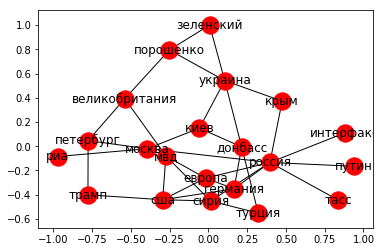

In [23]:
nx.draw_networkx(graph)

In [24]:
for e in graph.edges(data=True):
    print(e)

('украина', 'киев', {'marked': True, 'arrows': ['киев']})
('украина', 'донбасс', {'marked': False, 'arrows': ['украина', 'украина', 'донбасс']})
('украина', 'порошенко', {'marked': False, 'arrows': ['украина', 'украина', 'порошенко']})
('украина', 'зеленский', {'marked': False, 'arrows': ['украина']})
('украина', 'крым', {'marked': False, 'arrows': ['украина', 'украина', 'украина', 'крым']})
('сша', 'трамп', {'marked': False, 'arrows': ['сша', 'сша', 'сша']})
('сша', 'европа', {'marked': False, 'arrows': ['сша', 'сша', 'европа']})
('сша', 'мвд', {'marked': False, 'arrows': ['сша', 'мвд']})
('сша', 'сирия', {'marked': False, 'arrows': ['сша', 'сша', 'сша', 'сирия']})
('сша', 'германия', {'marked': False, 'arrows': ['сша', 'сша', 'сша', 'германия', 'германия']})
('россия', 'москва', {'marked': False, 'arrows': ['россия', 'россия', 'россия', 'россия', 'россия', 'москва', 'москва', 'москва']})
('россия', 'тасс', {'marked': False, 'arrows': ['россия', 'россия', 'россия', 'россия', 'россия',

#### Найдем центральную сущность

In [25]:
vertex_dict = {v : 0 for v in vertexes}

for edge in graph.edges(data=True):
    vertex_dict[edge[0]] += 1
    vertex_dict[edge[1]] += 1

In [26]:
vertex_dict

{'украина': 5,
 'сша': 5,
 'россия': 8,
 'москва': 4,
 'киев': 3,
 'тасс': 1,
 'трамп': 2,
 'риа': 1,
 'донбасс': 4,
 'европа': 4,
 'порошенко': 3,
 'зеленский': 2,
 'путин': 1,
 'крым': 2,
 'мвд': 4,
 'сирия': 4,
 'турция': 2,
 'германия': 4,
 'петербург': 3,
 'интерфакс': 1,
 'великобритания': 3}

In [30]:
list_d = list(vertex_dict.items())
list_d.sort(key=lambda i: i[1])
list_d[-1][0]

'россия'

![Rossiya](guber.jpg "Rossiya")

In [35]:
connected = []

for e in graph.edges(data=True):
    if e[0] == 'россия':
        connected.append(e[1])

In [36]:
connected

['москва', 'тасс', 'европа', 'путин', 'крым', 'сирия', 'германия', 'интерфакс']

Посчитаем ACE упоминания центральной сущности 'россия' при упоминании (и отсутствии упоминания) сущностей, от которых она зависит

In [38]:
for entity in connected:
    effect = CausalEffect(dataframe, [entity], ['россия'], 
                          variable_types={v:'u' for v in vertexes},
                          admissable_set=[])

    mentioned = pd.DataFrame({entity: [1], 'россия': [1]})
    neg_mentioned = pd.DataFrame({entity: [0], 'россия': [1]})
    print(entity, effect.pdf(mentioned) - effect.pdf(neg_mentioned))

москва 0.19564343614726765
тасс 0.17549776247246285
европа 0.20601604878994073
путин 0.4634151687508559
крым 0.3674410460966729
сирия 0.353051136621729
германия 0.2195279080933759
интерфакс 0.15977951745888502


Посчитаем вероятности упоминания центральной сущности 'россия' при упоминании (и отсутствии упоминания) сущностей, от которых она зависит

In [44]:
for entity in connected:
    p_mentioned = np.dot(dataframe['россия'].values, dataframe[entity].values) / n
    p_neg_mentioned = np.dot(dataframe['россия'].values, 1 - dataframe[entity].values) / n
    print('Вероятность_{}: упомянут = {:.2f}, не упомянут = {:.2f}'.format(entity, p_mentioned, p_neg_mentioned))

Вероятность_москва: упомянут = 0.11, не упомянут = 0.34
Вероятность_тасс: упомянут = 0.06, не упомянут = 0.38
Вероятность_европа: упомянут = 0.03, не упомянут = 0.41
Вероятность_путин: упомянут = 0.07, не упомянут = 0.37
Вероятность_крым: упомянут = 0.03, не упомянут = 0.42
Вероятность_сирия: упомянут = 0.02, не упомянут = 0.42
Вероятность_германия: упомянут = 0.03, не упомянут = 0.42
Вероятность_интерфакс: упомянут = 0.03, не упомянут = 0.41


В качестве вывода можно сказать, что в новостях ленты в основном речь идет о России, Довольно часто вместе с Россией упоминается и Владимир Владимирович, чего, в принципе, и стоило ожидать.